In [30]:
# Some quick exploration and visualisation of tweet data from the week around summit! Funz!
# What we will do is:
# 1. Look at some overall stats by hour.
# 2. Do a bit of processing on the tweets to determine most popular words per hour and perhaps build an interactive bokeh chart!

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [31]:
# Lets just start with some basic exploratory analysis
df = pd.read_csv('all_tweets.csv')

In [32]:
df.head()

,id,tweet_id,user_id,loc,coords,text,created_on
0,1,859060326385451009,7328382,France,NaN,AppNexus lance les 'super- enchères' https://t...,2017-05-01 15:01:59
1,2,859075195054604288,3031804453,"San Francisco, CA",NaN,"AppNexus Launches Multimedia ""Superauction"" Te...",2017-05-01 16:01:04
2,3,859087787915694080,3300616253,NaN,NaN,Partner Spotlight: #AppNexus Is The Worlds Le...,2017-05-01 16:51:06
3,4,859134706511736836,2772428497,"SoCal, Galaxy far far away",NaN,RT @ShiraOvide: Since the fall we've had IPO f...,2017-05-01 19:57:32
4,5,859135421095133185,41423673,"Atlanta, GA",NaN,AppNexus Launches Multimedia Auction Technolog...,2017-05-01 20:00:23


In [36]:
# Let's plot a count of tweets by hour.
df['created_on'] = pd.to_datetime(df['created_on'])
df['dh'] = df['created_on'].apply(lambda x: pd.to_datetime(x.strftime('%Y-%m-%d %H:00:00')))

In [42]:
by_hour = df.groupby('dh').agg('count')
by_hour.rename(columns={'id':'count_id'}, inplace=True)

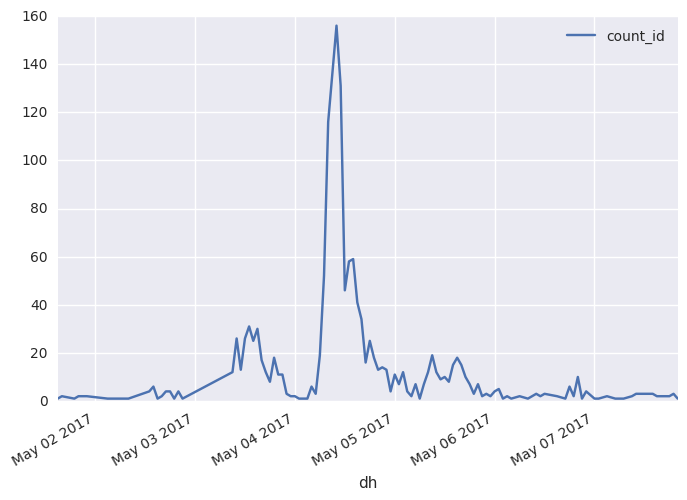

In [43]:
by_hour.plot(y='count_id')

Well it certainly seems pretty obvious as to when summit occurred! It would also be interesting to get some idea of the contents of tweets by hour.

In [66]:
# What we'll do to analyse tweet content is to python's NLTK library to help us determine
# the most popular words from all tweets in a given hour.

# Import some required nltk modules
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
from nltk import FreqDist

In [48]:
# First for each hour we want to concatenate the tweets together.
words_by_hour = df.groupby('dh')['text'].apply(lambda x: " ".join(x)).reset_index()

In [110]:
# Now we need to tokenize, remove stopwords and punctuation characters
def pre_process_text(sentence):
    
    # tokenize into a list of words with punctuation stripped
    wl = word_tokenize(sentence.translate(None, string.punctuation))
    
    # remove stopwords
    fw = [word.lower() for word in wl if word not in stopwords.words('english')]
    
    # remove some custom stopwords (appnexus and rt)
    custom_sw_list = ['appnexus', 'rt', 'appnexussummit']
    fw = [word for word in fw if word not in custom_sw_list]
    
    # remove all urls
    fw = [word for word in fw if not word.startswith('http')]
    
    return fw

words_by_hour['proc_text'] = words_by_hour['text'].apply(pre_process_text)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [111]:
# Now we have a list of words that appeared per hour.
# We need to process these to extract the top 3 most frequent
def find_most_frequent(words):
    
    # get the frequency distribution
    freq_dist = FreqDist(words)
    
    # return top 3
    return ",".join([word for word, _ in freq_dist.most_common(3)]).replace(" ","")

words_by_hour['top'] = words_by_hour['proc_text'].apply(find_most_frequent)

In [113]:
# We could probably apply better stopword filtering (e.g. for non english stopwords). But
# this is a short project, so no.

# Now let's generate an interactive bokeh plot! First import out bokeh and instantiate the JS
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models import HoverTool

output_notebook()

Loading BokehJS ...

In [115]:
# Merge our word data back into our counts
plt_df = pd.merge(by_hour.reset_index(), words_by_hour[['dh','top']], how='inner', on='dh')
plt_df['str_dh'] = plt_df['dh'].apply(lambda x: x.strftime('%Y-%m-%d %H'))

# Create the datasource
plt_ds = ColumnDataSource(plt_df)

p = figure(plot_width=1280, plot_height=500, tools='pan,reset', 
           title="Tweets about AppNexus over time!", x_axis_type='datetime', responsive=True)

p.line(x='dh', y='count_id', line_width=2, source=plt_ds)

# Set up our hovertool
hover = HoverTool(
    line_policy='nearest',
    mode='vline',
    tooltips=[
        ("Hour","@str_dh"),
        ("Number of Tweets","@count_id"),
        ("Top 3 Words","@top")
    ]
)

p.add_tools(hover)

show(p)

In [117]:
plt_df.to_csv('processed_tweets.csv', index=False)